In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import string
import theano

sns.set()
plt.ion()

# Functions and Classes

In [20]:
def compare(fitted_models):
    """
    Compare models on WAIC (and some other measures)

    In:
        fitted_models: iterable of FittedModel instances
        
    Out:
        DataFrame, indexed by model names, columns having comparison values
    """
    
    # variable needs to be Series instead of just list b/c 'pm.compare' returns dataframe which is sorted
    # by information criterion value. need to match model names to entries of that dataframe by index,
    # which indicates initial position of the model when given to this function
    # note: silly design by pymc3
    model_names = pd.Series([fm.name for fm in fitted_models])
    
    model_dict = {fm.model: fm.trace for fm in fitted_models}
    
    return (
        pm
        .compare(
            model_dict = model_dict,
            method = 'BB-pseudo-BMA'
        )
        .assign(model =  model_names)
        .set_index('model')
        .sort_values('WAIC')
    )

In [21]:
# Code 7.2

def create_rugged_log_gdp_model(dataset, return_dataframe=True):
    """
    model log_gdp as a linear function of ruggedness using data from `dataset`
    """
    with pm.Model() as model:
        sigma = pm.Uniform('sigma', 0, 10)
        bR = pm.Normal('bR', 0, 1)
        a = pm.Normal('a', 8, 100)
        mu = pm.Deterministic('mu', a + bR * dataset.rugged)
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

        trace = pm.sample(1000, tune=1000, progressbar=False)
        
        if return_dataframe:
            trace = pm.trace_to_dataframe(trace)
        
    return model, trace

In [22]:
def attach_mu_predictions_to_data(xy_data, trace_df):
    """
    For source data and a trace of posterior samples: calculate sample mean and hpd boundaries,
    attach them to the original data into one joined dataframe.
    
    Assume that 'mu__n' column of samples belongs to n-th data point in dataframe.
    
    In:
        xy_data: dataframe
        trace_df: dataframe having columns with name pattern 'mu__x'
        
    Out:
        'xy_data' dataframe with new columns 'mu_means', 'mu_hpd_lower', and 'mu_hpd_upper'
    """
    
    mu_samples = trace_df.filter(like='mu__')
    mu_means = mu_samples.mean(axis=0)

    mu_hpd_lower, mu_hpd_upper = np.split(
        ary=pm.hpd(mu_samples.values, alpha=0.03),
        indices_or_sections=2,
        axis=1
    )

    return (
        xy_data
        .assign(
            mu_means = mu_means.values,
            mu_hpd_upper = mu_hpd_upper,
            mu_hpd_lower = mu_hpd_lower
        )
    )

In [23]:
def create_plot_scatter_with_predicted_means(xy_data, trace_df, x, y, ax = None, plot_y = True):
    """
    Make predictions from samples, attach them to original data and plot original data and
    predictions together
    
    In:
        xy_data: dataframe with columns 'x' and 'y'
        trace_df: dataframe with posterior samples
        x: string col name
        y: string col name
        ax: what axes to plot into
    
    Out:
        ax: axes with plot
    """
    
    # calculate sample summaries and attach to original data
    # sort by x for plotting line of predicted mu values
    d_with_preds = attach_mu_predictions_to_data(xy_data, trace_df).sort_values(x)

    if ax is None:
        ax = plt.axes()

    ax.plot(x, 'mu_means', 'g-', data=d_with_preds)
    ax.fill_between(x, 'mu_hpd_lower', 'mu_hpd_upper', color='g', alpha=.3, data=d_with_preds)
    
    if plot_y:
        ax.plot(x, y, 'ob', mew=1, fillstyle='none', alpha=.3, data=d_with_preds)
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    return ax

In [24]:
class FittedModel(object):
    """
    Container to hold pymc3 model together with its mcmc trace and theano shared variables for prediction
    """
    
    def __init__(self, model, trace, predictor_dict, name):
        """
        model: pymc3 model
        trace: pymc3 trace for model
        predictor_dict = {'predictor_n': theano_tensor_n}
        """
        self.model = model
        self.trace = trace
        
        if predictor_dict is None:
            self.predictor_dict = None
        else:
            self.predictor_dict = {
                predictor_name: {
                    'shared_variable': shared_variable,
                    'original_value': shared_variable.get_value()
                }
                for predictor_name, shared_variable in predictor_dict.items()
            }
        self.name = name
        
    def _repr_latex_(self):
        return self.model._repr_latex_()
    
    
    def _set_predictor_values(self, predictor_values):
        """
        Set values of shared theano tensors to given values
        
        In:
            predictor_values: DataFrame, column = predictor
        
        Out:
            None, only side effects
        """
        
        # set shared variables to passed values
        for predictor_name in predictor_values.columns:
            predictor_shared_variable = self.predictor_dict[predictor_name]['shared_variable']
            predictor_shared_variable.set_value(predictor_values[predictor_name].values)
        
        
    def _reset_predictor_values(self):
        """
        Revert all shared variables to original state
        
        In:
            none
            
        Out:
            None
        """

        for _,  pred_dict in self.predictor_dict.items():
            pred_dict['shared_variable'].set_value(pred_dict['original_value'])
    
    
    def sample_mu(self, predictor_values):
        """
        Generate samples of 'mu' variable based on 'predictor_values' (yes, this is basically
        the 'link' function, just as a method).
                
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with samples for means, one column per input data point
        """

        # set shared variables to passed values
        self._set_predictor_values(predictor_values)

        samples = pm.sample_ppc(
            trace=self.trace, 
            model=self.model, 
            vars=[self.model.mu],
            progressbar=False
        )

        # revert shared variables to original state
        # if skipped all future interactions with model will use predictor values passed for this
        # function call as a side effect. makes reasoning harder.
        # TODO: make this automatic, e.g. through modifying shared variables only in context
        self._reset_predictor_values()

        mu_samples = samples['mu']

        columns = ['mu__{}'.format(i) for i in range(mu_samples.shape[1])]

        return pd.DataFrame(data=mu_samples, columns=columns)
    
    def predict_mu(self, predictor_values):
        """
        Generate mean/hpd predictions for mu based on 'predictor_values'. Closest to model.predict()
        in sklearn
        
        In:
            predictor_values: DataFrame with column names matching this_model.predictor_dict.keys()

        Out:
            df with mean and hpd of estimated mus, each row matches one input row of predictor_values df
        """
        
        mu_samples = self.sample_mu(predictor_values)

        mu_means = mu_samples.mean(axis=0)

        mu_hpd_lower, mu_hpd_upper = np.split(
            ary=pm.hpd(mu_samples.values, alpha=0.03),
            indices_or_sections=2,
            axis=1
        )

        # 'squeeze()' necessary to remove empty 2nd axis, pandas complains otherwise
        return pd.DataFrame(
            {
                'mu_means': mu_means, 
                'mu_hpd_lower': mu_hpd_lower.squeeze(), 
                'mu_hpd_upper': mu_hpd_upper.squeeze()
            }
        )

In [25]:
def link(fitted_model, predictor_values):
    """
    Generate samples of 'mu' variable for 'fitted_model' based on 'predictor_values'

    In:
        fitted_model: FittedModel instance
        predictor_values: DataFrame with column names matching fitted_model.predictor_dict.keys()
        
    Out:
        df with samples for means, one column per input data point
    """

    return fitted_model.sample_mu(predictor_values)

In [26]:
def precis(fitted_model):
    """
    Take a fitted model, give summaries about posterior estimates
    
    In:
        fitted_model: instance of FittedModel
    
    Out:
        pandas df with posterior summaries
    """
    
    summary =  pm.summary(fitted_model.trace, alpha=.11)

    # filter out deterministic variables
    # recognized by the '__'  in the name
    return summary.loc[[ix for ix in summary.index if '__' not in ix]]

In [27]:
def extract_samples(fitted_model):
    """
    In:
        fitted_model: FittedModel instance
        
    Out:
        DataFrame with posterior samples of parameters
    """
    
    return pm.trace_to_dataframe(fitted_model.trace)

# 7 Interactions

Conditioning: data conditional on how we get our samples. Posterior distributions conditional on data. All inference conditional on the model. Every inference is conditional, but we might not realize it.

Lin model = way of seeing outcome as conditional on predictors of that case.

Lin model assumes each predictor has independent association w/ mean of outcome **how does this work if interpretation of coefficient is "amount information gained when learning about this variable, already knowing all others"? probably doesn't work. need more basic interpretation. maybe "coefficent = expected change in outcome mean for unit increase in predictor, while keeping other predictors constant". still linked somehow?**

Ex: assume that link between brain size and milk energy depends on what kind of primate we are looking at (ape, monkey, prosimian). Influence needs to be conditional on that. McElreath: Lin. model in previous chapters cannot capture this. **again seems to indicate that we cannot use interpretation of 'given all other factors, how much do we learn about milk energy by getting information about brain size'. because 'all other factors' would include 'kind of primate'. which is weird, because is this not what 'statistically controlling for' would imply? we put in the another predictor into the model and thus control for it. more questions, not more answers. need discussion.**

want to model: importance of predictor A depends on predictor B. need: interaction. simplest one: linear interaction. see below.

## 7.1. Building an interaction

In [28]:
# Code 7.1

d = pd.read_csv('./data/rugged.csv', sep=';').set_index('isocode')

# make log version of outcome
d = d.assign(log_gdp=np.log(d.rgdppc_2000))

# drop incomplete cases
dd = d.dropna(subset=['rgdppc_2000'])

# split countries into africa and not-africa
d_a1 = dd.query('cont_africa == 1')
d_a0 = dd.query('cont_africa == 0')

In [29]:
# african countries
m_7_1, trace_7_1 = create_rugged_log_gdp_model(d_a1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


In [30]:
# non-african countries
m_7_2, trace_7_2 = create_rugged_log_gdp_model(d_a0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


Text(0.5, 1.0, 'Non-African countries')

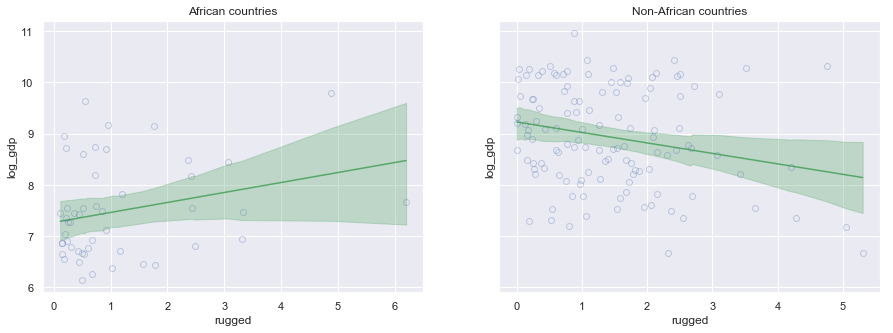

In [31]:
x = 'rugged'
y = 'log_gdp'

fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_a1, trace_7_1, x, y, axes_array[0])
ax.set_title('African countries')

ax = create_plot_scatter_with_predicted_means(d_a0, trace_7_2, x, y, axes_array[1])
ax.set_title('Non-African countries')

Slope different, but bad idea to split data into two frames like this because:

* now assumes variance (sigma) is different between african and non-african countries
* can't make statements about predictive power/uncertainty of 'is_african' variable used to split data
* can't use information criteria to compare models b/c fitted on different data
* can't use information from non-african countries for african countries/vice versa, which is done in multilevel models

Instead, create one model that allows different slope based on predictor values

### 7.1.1. adding a dummy variable doesn't work

In [32]:
# Code 7.3

m, t = create_rugged_log_gdp_model(dd, return_dataframe=False)

fit_m_7_3 = FittedModel(m, t, None, 'm_7_3')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]


In [33]:
# Code 7.4

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)


# object for easier bookkeeping
fit_m_7_4 = FittedModel(
    model = model,
    trace = trace,
    predictor_dict = {
        'rugged': rugged,
        'cont_africa': cont_africa
    },
    name = 'm_7_4'
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]


In [34]:
# Code 7.5
compare(
    [
        fit_m_7_3,
        fit_m_7_4
    ]
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_4,476.01,4.13,0,1,15.93,0,1
m_7_3,539.81,2.75,63.8,0,12.45,14.56,0


Text(0.5, 1.0, 'African countries')

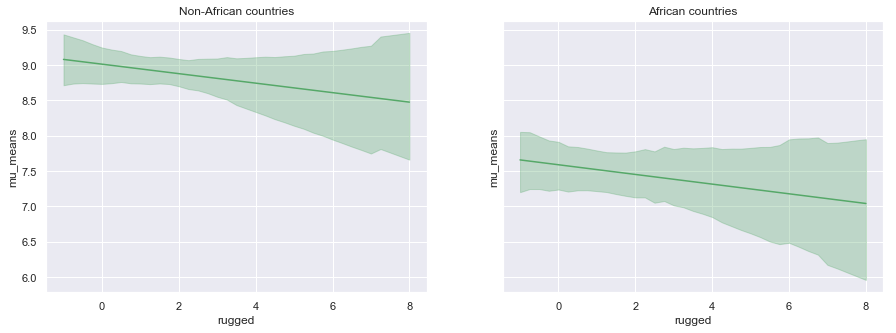

In [35]:
# Code 7.6

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create posterior samples of mu for predictor values
mu_not_africa = link(fit_m_7_4, d_not_africa)
mu_africa = link(fit_m_7_4, d_africa)

# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

No difference whatsoever in slope, perfectly parallel, just shifted. Can't change slope by including dummy variable. Model is only better in terms of WAIC b/c it allows model to capture fact that African nations on average have lower GDP

### 7.1.2. Adding a linear interaction does work

In [36]:
# Code 7.7

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    gamma = pm.Deterministic('gamma', bR + bAR * cont_africa)
    mu = pm.Deterministic('mu', a + gamma * rugged + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


In [37]:
fit_m_7_5 = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa}, 'm_7_5')

In [38]:
# Code 7.8

compare(
    [
        fit_m_7_3,
        fit_m_7_4,
        fit_m_7_5
    ]
)

/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/envs/rethinking_statistics/lib/python3.7/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m_7_5,469.38,5.01,0,0.85,14.16,0,1
m_7_4,476.01,4.13,6.63,0.15,14.45,5.74,1
m_7_3,539.81,2.75,70.43,0,12.71,14.6,0


**note** WAIC similar to book. weights diverge, m_7_5 has 97% of weight in book instead of 83% here

unclear what information criteria mean in this context. McElreath: "reasonable people can disagree on this".

Author thinks IC still useful, even if we don't have train/test case, i.e. we are not going to draw more samples from process that creates African/Non-African nations and predict for those. However, WAIC measures flexiblity of model in general, can still warn about overfitting.

**overthinking: conventional form of interaction** interaction model can also be written by multiplying predictors, yielding this:

$$
\mu_i = \alpha + \beta_R R_i + \beta_{AR} R_i*A_i + \beta_A A_i
$$

equivalent to form earlier in this chapter, just have to multiply out the $\gamma_i$ factor back into the original term.

Can also use this form to fit model:

In [39]:
# Code 7.9

dataset = dd

with pm.Model() as model:
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    bR = pm.Normal('bR', 0, 1)
    bA = pm.Normal('bA', 0, 1)
    bAR = pm.Normal('bAR', 0, 1)
    
    a = pm.Normal('a', 8, 100)
    
    rugged = theano.shared(dataset.rugged.values)
    cont_africa = theano.shared(dataset.cont_africa.values)
    
    mu = pm.Deterministic('mu', a + bR * rugged + bAR * rugged * cont_africa + bA * cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dataset.log_gdp)

    trace = pm.sample(1000, tune=1000, progressbar=False)

fit_m_7_5_b = FittedModel(model, trace, {'rugged': rugged, 'cont_africa': cont_africa}, 'm_7_5_b')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bAR, bA, bR, sigma]


### 7.1.3. Plotting interactions

In [40]:
# Code 7.10

# range of x-values
rugged_values = np.arange(-1, 8.25, 0.25)

# dataframes with predictor values
d_not_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 0})
d_africa = pd.DataFrame({'rugged': rugged_values, 'cont_africa': 1})

# create mu samples for posterior estimates based on above data
mu_not_africa = fit_m_7_5.sample_mu(d_not_africa)
mu_africa = fit_m_7_5.sample_mu(d_africa)

Text(0.5, 1.0, 'African countries')

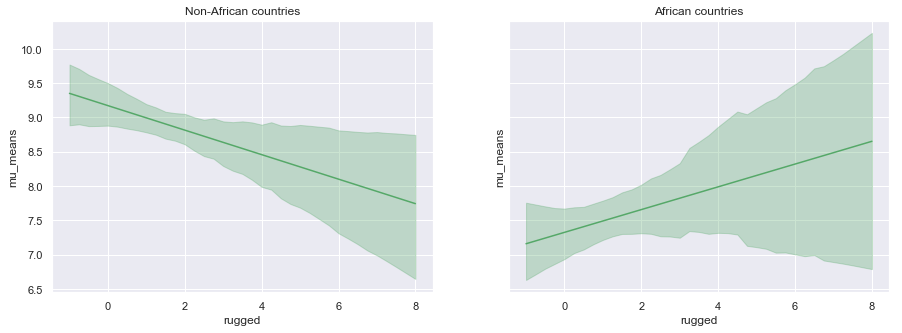

In [41]:
# Code 7.11

# x/y variable names
x = 'rugged'
y = 'mu_means'

# plots
fig, axes_array = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

ax = create_plot_scatter_with_predicted_means(d_not_africa, mu_not_africa, x, y, axes_array[0], plot_y=False)
ax.set_title('Non-African countries')

ax = create_plot_scatter_with_predicted_means(d_africa, mu_africa, x, y, axes_array[1], plot_y=False)
ax.set_title('African countries')

In [42]:
pm.trace_to_dataframe(fit_m_7_5.trace).mean().filter(like='b')

bR    -0.179356
bA    -1.834622
bAR    0.339902
dtype: float64

### 7.1.4. Interpreting an interaction estimate

Effect in non-interaction model does not mean the same thing as effect of same predictor in interaction model. Generally intepretation is hard, plots preferred to tables of number. Difficulties:

#### 7.1.4.1. Parameters change meaning

Lin. regression w/o interactions: coefficient = how much average outcome $\mu$ changes when predictor changes by one unit.

All parameters have independent influence on outcome, meaning can interpet coefficients independently. Each slope parameter = measure of predictor variable's influence.

Not true anymore for interaction models. $\gamma$ depends on bR, bAR and Ai, need to know all of these to compute that slope.

In [43]:
# Code 7.12

precis(fit_m_7_5)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
bR,-0.179356,0.074878,0.002313,-0.301099,-0.063479,979.184438,1.007333
bA,-1.834622,0.221226,0.006795,-2.203632,-1.503660,1044.549809,1.003757
bAR,0.339902,0.132171,0.003701,0.132603,0.547533,1157.873304,1.002187
a,9.175268,0.137189,0.004303,8.956155,9.397847,933.133640,1.007873
sigma,0.951354,0.052748,0.001043,0.864637,1.033585,1987.128507,1.000425


#### 7.1.4.2. Incorporating uncertainty

$\gamma$ has distribution because it depends on parameters, which in turn have distributions. **anything calculated using parameters has a distribution**. "one of the most important concepts on Bayesian model fitting"

In [44]:
# Code 7.13

post = extract_samples(fit_m_7_5)
gamma = pd.DataFrame(
    data=[
        post.bR + post.bAR * 1, 
        post.bR + post.bAR * 0
    ], 
    index=['africa', 'not_africa']
).T

In [45]:
# Code 7.14

gamma.mean()

africa        0.160546
not_africa   -0.179356
dtype: float64

Text(0, 0.5, 'density')

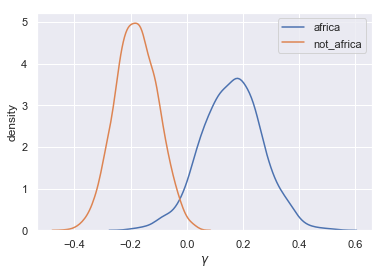

In [46]:
# Code 7.15

sns.kdeplot(gamma.africa)
sns.kdeplot(gamma.not_africa)

ax = plt.gca()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('density')

In [47]:
# Code 7.16

# probability of slope in africa being smaller than slope outside of africa
(gamma.africa < gamma.not_africa).mean() * 100

0.6

Note: 0.4% much smaller than visual overlap in figur above. Reason: figure shows marginal of each case "like silhouettes of each distribution". Not actually distribution of difference. "If you care about the difference, you must compute the disribution of difference directly". Same mechanism why overlap of confidence intervals can't be used as visual test of significance for parameter estimates

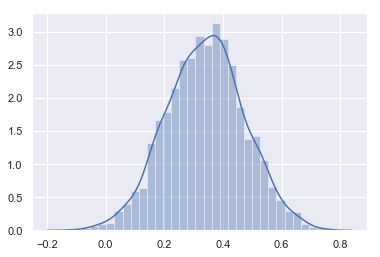

In [48]:
# So what is the distribution of differences?

sns.distplot(gamma.africa - gamma.not_africa)

Rethinking: More on the meaning of posterior probability. 0.4% is *not* probability of observing an event. Don't expect 0.36% of African nations to have worse impact of ruggedness on log gdp than country outside of Africa. 

Actual meaning: relative plausibilty for question asked given this model and these data. Model assigns very low plausibilty for $\gamma$ being lower in Africa than outside. Of known possible states of the world (**question: possible states of the world = coefficient values?**) only 0.4% are consistent with that being the case and with the data.

Model is highly sceptical of that being the case, but we should also keep being sceptical of the model

## 7.2. Symmetry of the linear interaction

### 7.2.1. Buridan's interaction

When expanding interaction term to conventional form it's obvious to see that it's symmetrical between the two predictors it involves:

$$
\mu_i = \alpha + \beta_R R_i + \beta_{AR} R_i*A_i + \beta_A A_i
$$

it involves R_i and A_i in the same way.

Translated: how ruggedness impacts log_gdp depens on being in Africa or not. impact of being in Africa or not on log_gdp depends on ruggedness. Symmetrical in model.

No difference to model, but humans tend to give causal interpretation. Easier to think about changing one predictor than the other. Easier to think about changing ruggedness thant whether a nation is in Africa

### 7.2.2. Africa depends on ruggedness

In [ ]:
# Code 7.17

